<div style="display: flex; justify-content: center;">
    <div style="background-color: #f4f6f7; padding: 15px; width: 80%;">
        <table style="width: 100%">
            <tr>
                <td style="vertical-align: middle;">
                    <span style="font-size: 14px;">
                        This is an extension notebook for <a href="https://www.thelmbook.com" target="_blank" rel="noopener">The Hundred-Page Language Models Book</a> by Andriy Burkov<br><br>
                        Code repository: <a href="https://github.com/aburkov/theLMbook" target="_blank" rel="noopener">https://github.com/aburkov/theLMbook</a>
                    </span>
                </td>
                <td style="vertical-align: middle;">
                    <a href="https://www.thelmbook.com" target="_blank" rel="noopener">
                        <img src="https://thelmbook.com/img/book.png" width="80px" alt="The Hundred-Page Language Models Book">
                    </a>
                </td>
            </tr>
        </table>
    </div>
</div>

# Coding GRPO from Scratch: A Guide to Distributed Implementation with Qwen2.5-1.5B-Instruct

> If you purchased [the book](https://thelmbook.com/), you can claim $150 in free cloud GPU credits with [Lambda](https://lambdalabs.com/) by sending an email to [author@thelmbook.com](mailto:author@thelmbook.com). With these cloud credits you can launch a 8xA100 instance and follow all the steps of this tutorial, including the distributed training.

In this tutorial, we demonstrate how to build a distributed reinforcement learning (RL) pipeline using the GRPO (Group Relative Policy Optimization) method to finetune a language model for math, logic, and coding tasks. These are tasks for which there exist a unique correct answer that can be easily verified with the ground truth answer using a simple string comparison.

GRPO was invented by DeepSeek and used to finetune DeepSeek R1 and R1-Zero models to excel in math and logic tasks by learning to generate a chain of thought (CoT). You will find a detailed overview of how R1 and R1-Zero were trained in [this article](https://thelmbook.com/articles/#!./DeepSeek-R1.md).

The objective of this tutorial is to transform a generalist language model **Qwen2.5-1.5B-Instruct** into a math problem solver. We will code GRPO from scratch and then integrate it with several popular libraries and tools to implement a distributed training pipeline, including:

- **PyTorch:** For tensor operations and distributed training.
- **Hugging Face Transformers:** For loading pre-trained language models and tokenizers.
- **FlashAttention2:** For optimized attention mechanisms that help reduce memory usage and improve training speed.
- **Weights & Biases (wandb):** For experiment tracking, visualization, and model versioning.

The tutorial is organized into several parts. We start with the basic setup and imports, then move on to data formatting and answer extraction, dataset preparation, evaluation functions, reward functions, training setup and execution, and finally loading and testing the model. In the process, we implement the GRPO algorithm from scratch.

## Part 1: Basic Setup and Imports

In this first part, we install and import all necessary modules. We also set up our environment by configuring random seeds for reproducibility and initializing environment variables required for experiment tracking. In addition, we install and import libraries that provide optimized transformer attention mechanisms (FlashAttention2) and reporting (Weights and Biases):

In [ ]:
!pip install tf-keras # for some reason, Hugging Face cannot work without it
!pip install flash-attn # FlashAttention2
!pip install wandb # Weights and Biases
!pip install 'accelerate>=0.26.0'
!pip install transformers # Hugging Face Transformers API
!pip install datasets # Hugging Face Datasets API

# Import necessary libraries
# Basic Python libraries for various operations
import random
import copy
import re
import os
import numpy as np
import wandb

# PyTorch and related libraries for deep learning
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

# Hugging Face libraries for transformer models
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

def set_random_seed(seed: int = 42):
    """
    Set the random seed for reproducibility across Python, NumPy, and PyTorch.

    Args:
        seed (int): The seed value to use for random number generation.

    Returns:
        None

    Explanation:
        1. Sets seed for Python's built-in random module for basic random operations.
        2. Sets seed for NumPy, ensuring consistent random number generation in array operations.
        3. Sets seed for PyTorch CPU operations.
        4. If CUDA is available, sets seed for all GPU devices.
        5. Configures cuDNN to ensure deterministic behavior:
           - Sets deterministic flag to True, ensuring reproducible results.
           - Disables benchmarking to prevent algorithm selection based on hardware.

    Note:
        Setting deterministic behavior may impact performance but ensures consistent results
        across multiple runs, which is crucial for debugging and research.
    """
    # Set the seed for Python's built-in random module
    random.seed(seed)
    # Set the seed for NumPy
    np.random.seed(seed)
    # Set the seed for PyTorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior in cuDNN (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call the function to set random seed for reproducibility
set_random_seed(42)

# Set environment variables for Weights & Biases (wandb) logging
os.environ["WANDB_API_KEY"] = "USE YOUR KEY"
os.environ["WANDB_PROJECT"] = "GRPO-Qwen-1.5-Instruct-Multi-GPU"

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


The code above performs the following tasks:
- **Setting a random seed:** The `set_random_seed` function ensures reproducibility by setting the seed for Python's random module, NumPy, and PyTorch. It also configures PyTorch's cuDNN backend for deterministic behavior.
- **Environment variable configuration:** We set the `WANDB_API_KEY` and `WANDB_PROJECT` environment variables to enable experiment tracking with Weights & Biases.
- **Import of necessary packages:** The script imports all the necessary modules for the pipeline, including:
Below is a detailed explanation of what each import is for:
- **random:** Helps with dataset shuffling and random operations.
- **copy:** Provides functions for deep copying objects.
- **re:** Provides regular expression support for text processing.
- **numpy (np):** Enables numerical operations and array manipulation.
- **torch:** Provides GPU-accelerated tensor operations and deep learning primitives.
- **torch.nn:** Contains neural network modules and operations.
- **pad_sequence:** Handles padding of variable-length sequences for batch processing.
- **AutoTokenizer** & **AutoModelForCausalLM:** Load pre-trained language models and their tokenizers.
- **load_dataset:** Loads datasets from Hugging Face's datasets library.
## Part 2: Data Formatting and Answer Extraction
In this section, we define how our data is formatted and how to extract the answer segments from both the model's output and the dataset. To ensure that the model outputs its response in a consistent format, we define a system prompt. The prompt instructs the model to generate output in an XML-like format containing `<reasoning>` and `<answer>` tags. We then provide two functions:
1. **`extract_answer_from_model_output`:** This function takes the model's output text and extracts the content within the `<answer>` tags.
2. **`extract_answer_from_dataset`:** This function extracts the expected answer from the GSM8K dataset, which separates the answer using the `"####"` delimiter:

In [ ]:
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

def extract_answer_from_model_output(text):
   """
   Extracts the value from the last <answer> tag in the text.

   Args:
       text (str): The model-generated text containing XML-style <answer> tags.

   Returns:
       str or None: The content inside the <answer> tags, or None if no valid answer is found.

   Explanation:
       1. Splits the text on the <answer> tag to isolate content after the tag.
       2. Checks if at least one <answer> tag exists in the text.
       3. For the last <answer> segment:
          - Verifies it contains a closing </answer> tag.
          - Extracts only the content between the tags.
       4. Returns None if the answer is empty (just "...") or if tags are missing.
   """
   # Split on <answer> and take everything after the last occurrence
   parts = text.split("<answer>")
   if len(parts) < 2:  # No <answer> tag found
       return None
   last_part = parts[-1]

   # Extract content up to </answer>
   if "</answer>" not in last_part:
       return None
   answer = last_part.split("</answer>")[0].strip()
   return None if answer == "..." else answer

def extract_answer_from_dataset(text):
   """
   Extracts the answer from the GSM8K dataset examples.

   Args:
       text (str): The dataset example text containing a question and answer.

   Returns:
       str or None: The extracted answer part after the '####' delimiter, or None if not found.

   Explanation:
       1. Checks if the text contains the '####' delimiter that separates question from answer.
       2. If found, splits the text at this delimiter and returns the second part (the answer).
       3. The answer is stripped of leading/trailing whitespace.
       4. Returns None if no delimiter is present.
   """
   if "####" not in text:
       return None
   return text.split("####")[1].strip()

In the above code:

- **`SYSTEM_PROMPT`:** This string variable instructs the model to respond with its chain-of-thought in the `<reasoning>` tag and the final answer in the `<answer>` tag. The use of this consistent format makes it easier to extract and evaluate the answer.
- **`extract_answer_from_model_output`:** This function splits the generated text by the `<answer>` tag, ensuring that only the content within the last occurrence of the tag is extracted. If the tag is missing or the answer is not valid (for example, it is a placeholder `"..."`), the function returns `None`.
- **`extract_answer_from_dataset`:** Given that the GSM8K dataset separates the answer using a delimiter (`"####"`), this function extracts the expected answer by splitting the text on that delimiter.

## Part 3: Dataset Preparation

In this part we prepare the GSM8K dataset for training. GSM8K is a dataset of 8.5K high quality linguistically diverse grade school math word problems created by human problem writers. We will use the examples from this dataset to train our model in the reinforcement learning (RL) paradigm: the model will generate several sample probelem solutions, we will compare these solutions to the ground truth number from a GSM8K example and, if there's a match, we will provide a high reward to the RL algorithm (GRPO) which will update the model's weights so that the chance of getting the high reward next time is increased.

We first load the dataset from Hugging Face and then format each example to include a system prompt and a user prompt. We also extract the expected answer from the dataset. Two helper functions are defined here:

1. **`prepare_dataset`:** Loads and prepares the GSM8K dataset by creating a prompt that includes a system prompt (with the formatting instructions) and a user message (the question). It also extracts the answer from the dataset.
2. **`build_prompt`:** Concatenates the list of message dictionaries into a single prompt string. This ensures consistency in how the prompt is constructed during both training and inference.

In [ ]:
def prepare_dataset(split="train"):
   """
   Load and prepare the GSM8K dataset for training with string prompts.

   Args:
       split (str): The dataset split to load ("train" or "test"). Defaults to "train".

   Returns:
       list: A list of formatted examples, each containing a prompt string and answer.

   Explanation:
       1. Loads the GSM8K dataset from the Hugging Face datasets hub.
       2. For each example in the dataset:
          - Creates a list of messages with system prompt and the question.
          - Converts this list into a single string prompt using build_prompt().
          - Extracts the answer from the dataset example.
          - Creates a formatted example dictionary with prompt and answer.
       3. Returns the list of formatted examples ready for model training or evaluation.
   """
   data = load_dataset('openai/gsm8k', 'main')[split]
   formatted_data = []
   for example in data:
       # Convert list of messages to a single string prompt.
       prompt_str = build_prompt([
           {"role": "system", "content": SYSTEM_PROMPT},
           {"role": "user", "content": example["question"]}
       ])
       formatted_example = {
           "prompt": prompt_str,  # Now a string rather than a list.
           "answer": extract_answer_from_dataset(example["answer"])
       }
       formatted_data.append(formatted_example)
   return formatted_data

def build_prompt(messages):
   """
   Build a single prompt string from a list of messages.

   Args:
       messages (list): A list of message dictionaries, each with 'role' and 'content' keys.

   Returns:
       str: A concatenated string of all message contents.

   Explanation:
       1. Takes a list of message dictionaries in the typical chat format.
       2. Extracts the 'content' field from each message and strips whitespace.
       3. Joins all content strings with newlines to create a single prompt.
       4. This preserves the training format while converting from structured messages to a string.
   """
   return "\n".join([msg["content"].strip() for msg in messages])

## Part 4: Evaluation Functions

Evaluation is crucial to track the model's progress. In this part, we define functions that allow us to evaluate the model on a set of examples. The evaluation functions perform the following tasks:

- **Tokenize the prompt and generate a response:** The model's output is generated given the tokenized prompt.
- **Extract the predicted answer:** The answer is extracted from the generated response.
- **Compare the predicted answer with the expected answer:** This comparison is done using exact matching as well as numeric equivalence checks.

Two helper functions, `_extract_last_number` and `_extract_single_number`, are used to extract numbers from text. The main evaluation function, `evaluate_model`, uses these helpers to determine if the predicted answer is correct:

In [ ]:
def extract_last_number(text):
   """
   Extracts the last number appearing in the text.

   Args:
       text (str): The text to extract a number from.

   Returns:
       float or None: The last number in the text, or None if no number is found.

   Explanation:
       1. Removes dollar signs and percent symbols from the text.
       2. Uses regex to find a number that appears at the end of the text (possibly after whitespace).
       3. The pattern matches numbers that appear at the end of the string, with or without decimal points.
       4. Returns the found number as a float, or None if no match is found.
   """
   text = text.replace('$', '').replace('%', '')
   pattern = r'(?:^|\s|=)\s*(-?\d*\.?\d+)\s*$'
   match = re.search(pattern, text)
   return float(match.group(1)) if match else None

def extract_single_number(text):
   """
   Extracts a single number from text if exactly one number is present.

   Args:
       text (str): The text to extract a number from.

   Returns:
       float or None: The single number in the text, or None if zero or multiple numbers are found.

   Explanation:
       1. Uses regex to find all numbers in the text (including negative numbers and decimals).
       2. If exactly one number is found, returns it as a float.
       3. If zero or multiple numbers are found, returns None.
   """
   numbers = re.findall(r'-?\d*\.?\d+', text)
   return float(numbers[0]) if len(numbers) == 1 else None

def evaluate_model(model, tokenizer, eval_examples, device):
   """
   Evaluates the model on a set of examples and prints detailed results.

   Args:
       model: The language model to evaluate.
       tokenizer: The tokenizer for encoding inputs and decoding outputs.
       eval_examples (list): List of evaluation examples, each containing "prompt" and "answer".
       device: The device (CPU or GPU) to run evaluation on.

   Returns:
       float: The accuracy percentage (correct predictions / total examples * 100).

   Explanation:
       1. Sets the model to evaluation mode.
       2. For each example in the evaluation set:
          - Encodes the prompt and generates a response using the model.
          - Extracts the predicted answer from the generated response.
          - Compares the predicted answer with the expected answer using multiple methods:
            a. Exact string matching
            b. Single number extraction and comparison
            c. Last number extraction and comparison
          - Prints detailed information about each example.
       3. Calculates and returns the overall accuracy.
       4. Returns the model to training mode.
   """
   model.eval()
   correct = 0
   total = len(eval_examples)
   print("\n" + "="*50)
   print("EVALUATION ON", total, "EXAMPLES")
   print("="*50)

   for example in eval_examples:
       # Get the prompt and expected answer
       full_prompt = example["prompt"]
       expected = example["answer"]

       # Tokenize and generate response
       inputs = tokenizer.encode(full_prompt, return_tensors="pt").to(device)
       with torch.no_grad():
           outputs = model.generate(
               inputs,
               max_new_tokens=512,
               temperature=0.7,
               num_return_sequences=1,
               pad_token_id=tokenizer.pad_token_id,
               eos_token_id=tokenizer.eos_token_id,
               forced_eos_token_id=tokenizer.eos_token_id,
               early_stopping=False,
           )
       response = tokenizer.decode(outputs[0], skip_special_tokens=True)

       try:
           # Extract answer and check correctness
           predicted = extract_answer_from_model_output(response)

           # Try different matching methods
           if predicted == expected:  # Exact match
               is_correct = True
           else:
               # Try single number matching
               pred_num = extract_single_number(str(predicted))
               exp_num = extract_single_number(str(expected))
               if pred_num is not None and exp_num is not None and pred_num == exp_num:
                   is_correct = True
               else:
                   # Try last number matching
                   pred_num = extract_last_number(str(predicted))
                   exp_num = extract_last_number(str(expected))
                   is_correct = (pred_num is not None and exp_num is not None and
                               pred_num == exp_num)

           # Update counter for correct answers
           if is_correct:
               correct += 1

           # Print evaluation details
           print("\nPrompt:")
           print(full_prompt)
           print("\nExpected Answer:")
           print(expected)
           print("\nExtracted Answer:")
           print(predicted)
           print("\nFull Generated Response:")
           print(response)
           print("\nCorrect:", "✓" if is_correct else "✗")
           print("-"*50)

       except Exception as e:
           print("\nFailed to parse model output for prompt:")
           print(full_prompt)
           print("Error:", e)
           print("-"*50)

   # Calculate and print final accuracy
   accuracy = (correct / total) * 100
   print(f"\nAccuracy: {accuracy:.2f}% ({correct}/{total})")
   print("="*50)

   # Return model to training mode
   model.train()
   return accuracy

In the above code:

- `_extract_last_number` extracts the final numeric value from a text string, ensuring it is separated properly and free from extraneous symbols.
- `_extract_single_number` attempts to extract a single numeric value from a string and returns it only if one number is found.
- `evaluate_model`:  
  - Sets the model to evaluation mode.
  - Iterates over each evaluation example, builds the prompt, tokenizes it, and generates a response.
  - Extracts the predicted answer and compares it to the expected answer using exact matching and numeric equivalence (using the helper functions).
  - Logs and prints detailed evaluation information for each example and computes the overall accuracy.

## Part 5: Reward Functions

In reinforcement learning, reward functions guide the training process by providing feedback on the model's output. In our pipeline, we define two reward functions:

1. **`correctness_reward`:**  
   This function assigns rewards based on whether the generated answer is correct. It compares the extracted answer from the model output with the expected answer, using both exact string matching and numeric equivalence checks. A exact match earns a higher reward (2.0), while a match based on numeric equivalence receives a smaller reward (1.5).
   
2. **`format_reward`:**  
   This function encourages the model to adhere to the desired XML-like output format. It provides a small reward for the presence of the `<reasoning>`, `</reasoning>`, `<answer>`, and `</answer>` tags in the generated text. We use a relatively value of 0.05 for each of the four pieces because the model is already capable of using these tags from previous supervised finetuning step, so we give this small reward so that it doesn't forget to do that because of the RL updates.

In [ ]:
def correctness_reward(prompts, completions, answer, **kwargs):
   """
   Assigns a reward based on the correctness of the model's answer.

   Args:
       prompts (list): List of input prompts.
       completions (list): List of model completions, each containing content.
       answer (list): List of expected answers.
       **kwargs: Additional keyword arguments.

   Returns:
       list: List of numerical rewards for each completion.

   Explanation:
       1. Extracts the content from each completion.
       2. Extracts the answer portion from each response using extract_answer_from_model_output.
       3. Assigns rewards based on matching criteria:
          - 2.0 points for an exact match
          - 1.5 points for numeric equivalence (when values match but format differs)
          - 0.0 points for incorrect answers
       4. Tracks completion lengths for analysis.
   """
   responses = [completion[0]['content'] for completion in completions]
   extracted = [extract_answer_from_model_output(r) for r in responses]
   rewards = []
   for r, a in zip(extracted, answer):
       if r == a:  # Exact match case
           rewards.append(2.0)
       else:
           # Try numeric equivalence
           r_num = extract_single_number(str(r))
           a_num = extract_single_number(str(a))
           if r_num is not None and a_num is not None and r_num == a_num:
               rewards.append(1.5)
           else:
               rewards.append(0.0)
   # Log completion lengths
   completion_lengths = [len(response.split()) for response in responses]
   # rewards为一个(batch_size * num_generations,)的一维向量，记录了batch_size * num_generations个completion的reward
   return rewards

def format_reward(completions, **kwargs):
   """
   Assigns a reward for adhering to the desired XML format.

   Args:
       completions (list): List of model completions, each containing content.
       **kwargs: Additional keyword arguments.

   Returns:
       list: List of format compliance scores for each completion.

   Explanation:
       1. Extracts the content from each completion.
       2. Evaluates format compliance by checking for required XML tags:
          - 0.2 points for each tag present (<reasoning>, </reasoning>, <answer>, </answer>)
          - Maximum score of 0.8 for perfect format compliance
       3. Stores and returns the format compliance scores.
   """
   responses = [completion[0]['content'] for completion in completions]
   rewards = []
   format_scores = []
   for response in responses:
       score = 0.0
       if "<reasoning>" in response: score += 0.2
       if "</reasoning>" in response: score += 0.2
       if "<answer>" in response: score += 0.2
       if "</answer>" in response: score += 0.2
       rewards.append(score)
       format_scores.append(score)
   # rewards为一个(batch_size * num_generations,)的一维向量，记录了batch_size * num_generations个completion在格式上的reward
   return rewards

def combined_reward(prompts, completions, answer):
   """
   Combines correctness and format rewards.

   Args:
       prompts (list[str]): List of prompt texts
       completions (list[list[dict]]): List of completion dictionaries
       answer (list[str]): List of expected answers

   Returns:
       list[float]: Combined rewards for each prompt-completion pair

   Explanation:
       1. Calculates separate rewards for correctness and format compliance.
       2. Combines the rewards with the following weights:
          - Correctness score range: 0.0 to 2.0
          - Format score range: 0.0 to 0.8
          - Total possible range: 0.0 to 2.8
       3. Returns the combined reward for each example.
   """
   # Get individual rewards
   correctness_scores = correctness_reward(prompts=prompts, completions=completions, answer=answer)
   format_scores = format_reward(completions=completions)

   # Combine rewards - correctness is weighted more heavily
   combined_rewards = []
   for c_score, f_score in zip(correctness_scores, format_scores):
       # Correctness score range: 0.0 to 2.0
       # Format score range: 0.0 to 0.8
       # Total range: 0.0 to 2.8
       combined_rewards.append(c_score + f_score)

   return combined_rewards

## Part 6: DataParallel GRPO From Scratch

In this section, we implement all the building blocks of the GRPO algorithm from scratch. The implementation assumes that the machine running the code has at least 2 GPUs. We use PyTorch's `DataParallel` API to distribute the policy model across the GPU cores, one copy of the model per GPU core. The batch is split between the GPU cores.

In [ ]:
def selective_log_softmax(logits, input_ids):
    """
    Computes log probabilities for specific tokens in the vocabulary.

    Args:
        logits (torch.Tensor): The raw logits output from the model.
        input_ids (torch.Tensor): The token IDs for which we want the log probabilities.

    Returns:
        torch.Tensor: Log probabilities of the selected tokens.

    Explanation:
        1. Applies log softmax to convert logits to log probabilities over the vocabulary.
        2. Uses gather to extract only the log probabilities corresponding to the input_ids.
        3. Removes the extra dimension to match the original shape of input_ids.
    """
    # logits的size：(batch_size * num_generations, len(completion_ids), vocab_size)
    log_probs = nn.functional.log_softmax(logits, dim=-1)
    # output的size：(batch_size * num_generations, len(completion_ids))
    return log_probs.gather(dim=-1, index=input_ids.unsqueeze(-1)).squeeze(-1)

def compute_log_probs(model, input_ids, attention_mask, logits_to_keep):
    """
    Computes the log probabilities for a batch of tokens.

    Args:
        model: The language model.
        input_ids (torch.Tensor): Token IDs for input sequences.
        attention_mask (torch.Tensor): Attention mask for input sequences.
        logits_to_keep (int): Number of tokens to keep from the end of the sequence.

    Returns:
        torch.Tensor: Log probabilities of the selected tokens.

    Explanation:
        1. Gets logits from the model for the input sequence.
        2. Selects logits for all tokens except the last one (as we predict next tokens).
        3. Selects only the last 'logits_to_keep' tokens from both logits and input_ids.
        4. Computes log probabilities for these tokens using selective_log_softmax.
    """
    # logits的size：(batch_size * num_generations, sequence_length, vocab_size)
    logits = model(input_ids=input_ids, attention_mask=attention_mask).logits[:, :-1, :]
    # logits_to_keep==len(completion_ids)，即出去prompt_ids以外的completion_ids在dim=1上的维度
    input_ids = input_ids[:, -logits_to_keep:]
    logits = logits[:, -logits_to_keep:, :]
    # 节省运算量，只在dim=1上进行logits_to_keep个softmax运算
    return selective_log_softmax(logits, input_ids)

def create_completion_mask(completion_ids, eos_token_id):
    """
    Creates a mask for completion tokens that excludes tokens after the EOS token.

    Args:
        completion_ids (torch.Tensor): Token IDs of the generated completions.
        eos_token_id (int): The ID of the end-of-sequence token.

    Returns:
        torch.Tensor: A binary mask with 1s for valid tokens and 0s after the EOS token.

    Explanation:
        1. Identifies positions where EOS tokens occur in each sequence.
        2. Finds the index of the first EOS token in each sequence.
        3. Creates a mask where positions before and including the first EOS are 1, others are 0.
        4. If no EOS token is found in a sequence, all positions are set to 1.
    """
    # 结束符
    is_eos = completion_ids == eos_token_id
    # 创建一个idx，idx为一个size为(batch_size * num_generation,)的tensor，该tensor的每一个元素值均为max_completion_length
    eos_idx = torch.full((is_eos.size(0),), is_eos.size(1), dtype=torch.long, device=completion_ids.device)
    # mask_exists的size：(batch_size * num_generations,)
    mask_exists = is_eos.any(dim=1)
    # eos_idx为每个completion的eos_token_id出现的位置
    eos_idx[mask_exists] = is_eos.int().argmax(dim=1)[mask_exists]
    sequence_indices = torch.arange(is_eos.size(1), device=completion_ids.device).expand(is_eos.size(0), -1)
    # 生成mask，若is_eos为[[False,False,True],[False,True,False]]，则mask为[[1,1,1],[1,1,0]]
    return (sequence_indices <= eos_idx.unsqueeze(1)).int()

def generate_completions(model, tokenizer, prompts, num_generations=4, max_completion_length=32):
    """
    Generates multiple completions for each prompt.

    Args:
        model: The language model.
        tokenizer: The tokenizer for encoding and decoding text.
        prompts (list): List of text prompts.
        num_generations (int): Number of completions to generate per prompt.
        max_completion_length (int): Maximum number of tokens to generate.

    Returns:
        tuple: Containing prompt IDs, prompt mask, completion IDs, and completion mask.

    Explanation:
        1. Encodes the prompts and moves them to the appropriate device.
        2. Repeats each prompt num_generations times to generate multiple completions.
        3. Generates completions using the model with specified parameters.
        4. Extracts the completion IDs (excluding the prompt tokens).
        5. Creates a mask for the completions using create_completion_mask.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, padding_side="left")
    # (batch_size * num_generations, len(prompt_ids))
    prompt_ids = inputs["input_ids"].to(device)
    prompt_mask = inputs["attention_mask"].to(device)
    print(f"Input batch size: {prompt_ids.size(0)}, Device before model: {prompt_ids.device}")
    prompt_length = prompt_ids.size(1)
    # 将prompt_ids和prompt_mask在dim=0上复制num_generations份，再让加载好的预训练模型生成num_generations种不同的输出
    # prompt_ids、prompt_mask的size：(batch_size * num_generations, len(prompt_ids) + max_completion_length)
    prompt_ids = prompt_ids.repeat_interleave(num_generations, dim=0)
    prompt_mask = prompt_mask.repeat_interleave(num_generations, dim=0)
    # 针对一个prompt生成num_generations种不同的completion，completion长度为max_completion_length
    outputs = model.generate(
        prompt_ids,
        attention_mask=prompt_mask,
        max_new_tokens=max_completion_length,
        do_sample=True,
        temperature=1.0,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        early_stopping=False
    )
    print(f"Output batch size: {outputs.size(0)}, Device after model: {outputs.device}")
    # completion_ids、completion_mask的size：(batch_size * num_generations, max_completion_length)
    completion_ids = outputs[:, prompt_length:]
    # 创建completion mask，以eos_token_id为结束符
    completion_mask = create_completion_mask(completion_ids, tokenizer.eos_token_id)
    return prompt_ids, prompt_mask, completion_ids, completion_mask

def generate_rollout_data(model, ref_model, tokenizer, batch_samples, num_generations, max_completion_length):
    """
    Generates data for GRPO rollouts including completions and log probabilities.

    Args:
        model: The policy model being trained.
        ref_model: The reference model for KL divergence calculation.
        tokenizer: The tokenizer for encoding and decoding text.
        batch_samples (list): Batch of training samples.
        num_generations (int): Number of completions to generate per sample.
        max_completion_length (int): Maximum completion length.

    Returns:
        dict: Dictionary containing all data needed for GRPO updates.

    Explanation:
        1. Extracts prompts and expected answers from the batch samples.
        2. Generates completions using the current policy model.
        3. Combines prompt and completion tokens.
        4. Computes log probabilities from both the policy model and reference model.
        5. Formats completions for reward calculation.
        6. Repeats prompts and answers to match the number of generated completions.
        7. Returns all data needed for GRPO loss calculation.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # len(prompts) == len(answers) == batch_size
    prompts = [sample["prompt"] if isinstance(sample, dict) else sample[0] for sample in batch_samples]
    answers = [sample["answer"] if isinstance(sample, dict) else sample[1] for sample in batch_samples]
    with torch.no_grad():
        prompt_ids, prompt_mask, completion_ids, completion_mask = generate_completions(
            model, tokenizer, prompts, num_generations, max_completion_length
        )
        input_ids = torch.cat([prompt_ids, completion_ids], dim=1)
        attention_mask = torch.cat([prompt_mask, completion_mask], dim=1)
        logits_to_keep = completion_ids.size(1)
        old_log_probs = compute_log_probs(model, input_ids, attention_mask, logits_to_keep)
        ref_log_probs = compute_log_probs(ref_model, input_ids, attention_mask, logits_to_keep)
    # 将completion token id解码为字符
    formatted_completions = [[{'content': tokenizer.decode(ids, skip_special_tokens=True)}] for ids in completion_ids]
    repeated_prompts = [p for p in prompts for _ in range(num_generations)]
    repeated_answers = [a for a in answers for _ in range(num_generations)]
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "completion_mask": completion_mask,
        "old_log_probs": old_log_probs,
        "ref_log_probs": ref_log_probs,
        "formatted_completions": formatted_completions,
        "repeated_prompts": repeated_prompts,
        "repeated_answers": repeated_answers,
        "logits_to_keep": logits_to_keep,
        "batch_size": len(prompts),
        "num_generations": num_generations
    }

def grpo_loss(model, ref_model, rollout_data, tokenizer, reward_function, beta=0.01, epsilon=0.2):
    """
    Computes the GRPO loss for updating the policy model.

    Args:
        model: The policy model being trained.
        ref_model: The reference model for KL divergence calculation.
        rollout_data (dict): Data generated by generate_rollout_data.
        tokenizer: The tokenizer for encoding and decoding text.
        reward_function: Function that calculates rewards for completions.
        beta (float): KL penalty coefficient.
        epsilon (float): Clipping parameter for PPO.

    Returns:
        torch.Tensor: The GRPO loss to be minimized.

    Explanation:
        1. Computes current token log probabilities using the policy model.
        2. Calculates the probability ratio between current and old policies.
        3. Computes rewards using the provided reward_function.
        4. Calculates advantages by standardizing rewards within each prompt.
        5. Computes the PPO surrogate objective with clipping.
        6. Calculates the KL divergence between reference and policy models.
        7. Combines surrogate loss and KL penalty.
        8. Averages the loss across all tokens and batches.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    input_ids = rollout_data["input_ids"]
    attention_mask = rollout_data["attention_mask"]
    completion_mask = rollout_data["completion_mask"]
    logits_to_keep = rollout_data["logits_to_keep"]
    old_log_probs = rollout_data["old_log_probs"]
    ref_log_probs = rollout_data["ref_log_probs"]
    token_log_probs = compute_log_probs(model, input_ids, attention_mask, logits_to_keep)
    # ratio=e**(token_log_probs) / e**(old_log_probs)，即prob_new / prob_old
    ratio = torch.exp(token_log_probs - old_log_probs)
    rewards = torch.tensor(
        reward_function(prompts=rollout_data["repeated_prompts"], completions=rollout_data["formatted_completions"], answer=rollout_data["repeated_answers"]),
        dtype=torch.float32,
        device=device
    )
    #print(f"Rewards: {rewards}")  # Debug rewards
    batch_size = rollout_data["batch_size"]
    num_generations = rollout_data["num_generations"]
    rewards = rewards.view(batch_size, num_generations)
    avg_reward = rewards.mean().item()
    print("Average Reward:", avg_reward)
    # mean_rewards的size：(batch_size * num_generations,)
    mean_rewards = rewards.mean(dim=1).repeat_interleave(num_generations)
    # std_rewards的size：(batch_size * num_generations,)
    std_rewards = rewards.std(dim=1).repeat_interleave(num_generations)
    # advantages指的是每个completion相对于平均值的优势，size为(batch_size * num_generations,)
    advantages = ((rewards.view(-1) - mean_rewards) / (std_rewards + 1e-4)).unsqueeze(1)
    # ratio的size：(batch_size * num_generations, len(completion_ids))
    surr1 = ratio * advantages
    surr2 = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantages
    surrogate_loss = torch.min(surr1, surr2)
    kl = torch.exp(ref_log_probs - token_log_probs) - (ref_log_probs - token_log_probs) - 1
    per_token_loss = surrogate_loss - beta * kl
    loss = -((per_token_loss * completion_mask).sum(dim=1) / completion_mask.sum(dim=1)).mean()
    return loss, avg_reward

def train_with_grpo(model, tokenizer, train_data, num_iterations=1, num_steps=500, batch_size=4,
                              num_generations=4, max_completion_length=128, beta=0.1,
                              learning_rate=5e-6, mu=3, epsilon=0.2, reward_function=None, device_ids=None):
    """
    This function is your original working code (train_with_grpo_static)
    with an added outer loop for iterative GRPO updates per the pseudocode.

    Args:
        model: The language model to train.
        tokenizer: The tokenizer for encoding and decoding text.
        train_data (list): Training dataset.
        num_iterations (int): Number of outer iterations (reference model updates).
        num_steps (int): Number of batch updates per iteration.
        batch_size (int): Number of prompts per batch.
        num_generations (int): Number of completions per prompt.
        max_completion_length (int): Maximum token length for completions.
        beta (float): KL penalty coefficient.
        learning_rate (float): Learning rate for optimizer.
        mu (int): Number of policy updates per batch.
        epsilon (float): PPO clipping parameter.
        reward_function: Function that calculates rewards for completions.
        device_ids (list): List of GPU device IDs for DataParallel.

    Returns:
        The trained model.

    Explanation:
        1. For each outer iteration:
           - Creates a reference model as a deep copy of the current policy model.
           - Reinitializes the optimizer for the policy model.
           - For each training step:
             a. Samples a batch of examples from the training data.
             b. Generates rollout data including completions and log probabilities.
             c. For mu iterations:
                i. Computes the GRPO loss.
                ii. Updates the policy model using gradient descent.
           - Monitors GPU memory usage and prints progress information.
    """
    assert device_ids is not None and len(device_ids) > 1, "This code needs at least 2 GPU cores to run!"

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Wrap model with DataParallel if multiple GPUs are available.

    model = nn.DataParallel(model, device_ids=device_ids)
    print(f"Model wrapped with DataParallel across GPUs: {device_ids}")

    # Outer loop: iterative GRPO updates.
    for iteration in range(num_iterations):
        print(f"\nIteration {iteration+1}/{num_iterations}")

        # Create a reference model (deep copy) and set it to eval mode.
        ref_model = copy.deepcopy(model.module)
        ref_model.eval()
        for param in ref_model.parameters():
            param.requires_grad = False
        print("Reference model created.")

        # Reinitialize the optimizer for this iteration.
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        model.train()

        # Inner loop: your original training steps.
        for step in range(num_steps):
            batch_samples = random.sample(train_data, batch_size)
            with torch.no_grad():
                rollout_data = generate_rollout_data(
                    model.module,
                    ref_model,
                    tokenizer,
                    batch_samples,
                    num_generations,
                    max_completion_length
                )
            for grpo_iter in range(mu):
                loss, avg_reward = grpo_loss(
                    model.module,
                    ref_model,
                    rollout_data,
                    tokenizer,
                    reward_function,
                    beta=beta,
                    epsilon=epsilon
                )
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
                optimizer.step()
                # Log to wandb
                wandb.log({
                    "loss": loss.item(),
                    "average_reward": avg_reward,
                    "iteration": iteration + 1,
                    "step": step + 1,
                    "grpo_iter": grpo_iter + 1
                })
                print(f"Iteration {iteration+1}/{num_iterations}, Step {step+1}/{num_steps}, "
                      f"GRPO iter {grpo_iter+1}/{mu}, loss: {loss.item():.4f}")
                #for i in range(torch.cuda.device_count()):
                #    print(f"GPU {i} Usage: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MiB, "
                #          f"Utilization: {torch.cuda.utilization(i)}%")
                # Uncomment to see the GPU utilization stats
    return model.module

## Part 7: Training Setup and Execution

In this section, we put together all components to set up and run the training. We begin by loading the pre-trained model and tokenizer, prepare evaluation data, and then do reinforcement learning (RL) fine-tuning using the our own `train_with_grpo` we implemented from scratch above.

Key steps include:

- **Model and Tokenizer Initialization:**  
  The model `"Qwen/Qwen2.5-1.5B-Instruct"` is loaded with optimized settings (using `torch.bfloat16` and FlashAttention2). The tokenizer is also loaded, and its padding token is set to the end-of-sequence token. Loading a model with `torch.bfloat16` converts its parameters to use 16 bits instead of 32 bits per number, which cuts the model's memory usage in half and can make training faster on modern GPUs.
  
- **Initial Evaluation:**  
  Before fine-tuning, the model is evaluated on a few examples to establish a baseline performance.
    
- **Reinforcement Learning Fine-Tuning (RL):**  
  The training function `train_with_grpo` implementing GRPO from scratch is configured with the appropriate training arguments and reward functions. The RL training then proceeds on the remaining training data.
  
- **Final Evaluation and Model Saving:**  
  After RL fine-tuning, the model is evaluated again, and the final model is saved.

In the code below:
  
- The device is determined (GPU if available, otherwise CPU).
- The pre-trained Qwen2.5-1.5B-Instruct model and tokenizer are loaded. The tokenizer's pad token is set to the eos_token.
- A small subset of the dataset is reserved for evaluation to provide a baseline.
- The model is optimized for memory efficiency by enabling gradient checkpointing and disabling KV caching.
- **Step 1:** The model is evaluated before fine-tuning to establish a baseline accuracy.
- **Step 2:** Reinforcement learning fine-tuning is performed using the `train_with_grpo` function with our defined reward functions (`format_reward` and `correctness_reward`, combined into `combined_reward`). The model is trained using a multi-GPU.
- **Step 3:** The final, fine-tuned model and tokenizer are saved to disk.

We used the following hyperparameters for our GRPO training pipeline:

### **Training Configuration**

These parameters configure the reinforcement learning fine-tuning run using the GRPO algorithm. We set them as follows:

- **num_iterations=1**  
  The number of outer iterations where a new reference model is created from the current policy model. One iteration is one pass over the entire dataset.

- **num_steps=500**  
  The training loop will perform a maximum of 500 steps, each processing a batch of examples.

- **batch_size=7**  
  Each step processes 7 examples per batch which, in the case of 8 GPUs, puts 1 example at each GPU. One GPU (0) is used as the master by `DataParallel` for aggregating gradients and gathering outputs.

- **num_generations=14**  
  For every prompt in the training data, the trainer will generate 14 different completions. These multiple generations are used to compute a relative advantage (or reward signal) that guides the RL update. Reduce this number if you have GPUs with less VRAM.

- **max_completion_length=400**  
  When generating completions (the "response" portion of the sequence), the generation is capped at 400 tokens. This limits the length of the outputs produced by the model during the RL phase. Reduce this number if you have GPUs with less VRAM.

- **beta=0.04**  
  The coefficient for the KL divergence penalty in the GRPO loss function. This controls how much the model is allowed to diverge from the reference model.

- **learning_rate=5e-6**  
  The learning rate for RL finetuning. A relatively low learning rate is used for stable policy updates.

- **mu=1**  
  The number of policy updates performed for each batch of rollout data. In our case, we perform just one update per batch.

- **epsilon=0.1**  
  The clipping parameter for the PPO component of GRPO. This prevents the policy from changing too drastically in a single update.

The model is evaluated both before and after fine-tuning to measure the improvement in accuracy. Finally, the fine-tuned model is saved to the "grpo_finetuned_model" directory.

In [ ]:
def optimize_model_memory(model):
    """
    Optimizes the model to use less memory during training.

    Args:
        model: The language model to optimize.

    Returns:
        The optimized model.

    Explanation:
        1. Sets the model to training mode.
        2. Disables KV caching to save memory.
        3. Enables gradient checkpointing to trade computation for memory.
        4. Ensures that input embeddings require gradients:
           - Either uses the built-in method if available.
           - Or adds a forward hook to the input embeddings layer.
        5. Returns the optimized model ready for memory-efficient training.
    """
    model.train()
    model.config.use_cache = False

    # First ensure inputs will require gradients
    if hasattr(model, "enable_input_require_grads"):
        model.enable_input_require_grads()
    else:
        def make_inputs_require_grad(module, input, output):
            output.requires_grad_(True)
        model.get_input_embeddings().register_forward_hook(make_inputs_require_grad)

    # Then enable gradient checkpointing
    model.gradient_checkpointing_enable()

    return model

# Main execution
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using primary device: {device}")

model_name = "Qwen/Qwen2.5-1.5B-Instruct"
output_dir = "math_solver_model"

print("Downloading model...")
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
print("Model downloaded")

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id
model.config.eos_token_id = tokenizer.eos_token_id

num_gpus = torch.cuda.device_count()
print(f"Detected {num_gpus} GPUs")
device_ids = list(range(num_gpus)) if num_gpus > 1 else None

all_data = prepare_dataset("train")
random.shuffle(all_data)
size_of_eval_data = 30 # change to a smaller value to save time or to a larger number for a more reliable estimate
eval_data = all_data[:size_of_eval_data]
train_data = all_data[size_of_eval_data:]

print("\nInitial model evaluation before finetuning:")
pre_grpo_accuracy = evaluate_model(model, tokenizer, eval_data, device)
print(f"Pre-GRPO Accuracy: {pre_grpo_accuracy:.2f}%")

model = optimize_model_memory(model)

print("\nStarting RL fine-tuning using GRPO...")
# This config was tested on a 8xA100 node, where each A100 is has 80GB of VRAM
training_config = {
    'num_iterations': 1,
    'num_steps': 500,
    'batch_size': 7, # reduce if you have fewer GPUs
    'num_generations': 12, # reduce if you have GPUs with less VRAM
    'max_completion_length': 400, # reduce if you have GPUs with less VRAM
    'beta': 0.04,
    'learning_rate': 5e-6,
    'mu': 1,
    'epsilon': 0.1
}

# Initialize Weights & Biases
wandb.init(project=os.environ["WANDB_PROJECT"], reinit=True)
print("Weights & Biases initialized.")

model = train_with_grpo(
    model=model,
    tokenizer=tokenizer,
    train_data=train_data,
    reward_function=combined_reward,
    device_ids=device_ids,
    **training_config
)

wandb.finish()
print("Training completed and wandb run finished.")

print("\nFinal model evaluation after GRPO RL fine-tuning:")
post_grpo_accuracy = evaluate_model(model, tokenizer, eval_data, device)
print(f"Post-GRPO Accuracy: {post_grpo_accuracy:.2f}%")

print("\nSaving GRPO fine-tuned model...")
model.save_pretrained("grpo_finetuned_model")
tokenizer.save_pretrained("grpo_finetuned_model")

Using primary device: cuda:0


2025-02-28 05:15:07.599762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740719707.618303    8248 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740719707.623906    8248 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Model downloaded
Detected 8 GPUs


Generating test split: 100%|██████████| 1319/1319 [00:00<00:00, 307622.72 examples/s]
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Initial model evaluation before finetuning:

EVALUATION ON 30 EXAMPLES

Prompt:
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant?

Expected Answer:
108

Extracted Answer:
The total amount of money that Stefan and his family spend at the restaurant is $108.

Full Generated Response:
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant? To calculate the total amount spent at the restaurant, we need to add up all the individual items ordered 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.



Prompt:
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
Jason's dog has a tail that's half the length of its body, and a head that's 1/6 the length of its body. If the dog is 30 inches long overall, how long is its tail?

Expected Answer:
9

Extracted Answer:
None

Full Generated Response:
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
Jason's dog has a tail that's half the length of its body, and a head that's 1/6 the length of its body. If the dog is 30 inches long overall, how long is its tail? To determine the length of Jason's dog's tail, we need to follow these steps:

1. **Identify the total length of the dog:**
   The dog is given as being 30 inches long overall.

2. **Define variables for different parts of the dog:**
   Let \( L \) represent the length of the entire dog.
   Let \( H \) represent the length of the head.
   Let \( T \) represent the length of the tail.

3. **Set up equations based on th

wandb: Currently logged in as: burkov to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Weights & Biases initialized.
Model wrapped with DataParallel across GPUs: [0, 1, 2, 3, 4, 5, 6, 7]

Iteration 1/1
Reference model created.
Input batch size: 7, Device before model: cuda:0


/usr/lib/python3/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Output batch size: 84, Device after model: cuda:0
Average Reward: 0.714285671710968
Iteration 1/1, Step 1/500, GRPO iter 1/1, loss: 0.0000
Input batch size: 7, Device before model: cuda:0
Output batch size: 84, Device after model: cuda:0
Average Reward: 0.7511904835700989
Iteration 1/1, Step 2/500, GRPO iter 1/1, loss: 0.0000
Input batch size: 7, Device before model: cuda:0
Output batch size: 84, Device after model: cuda:0
Average Reward: 1.1464285850524902
Iteration 1/1, Step 3/500, GRPO iter 1/1, loss: 0.0001
Input batch size: 7, Device before model: cuda:0
Output batch size: 84, Device after model: cuda:0
Average Reward: 1.3392857313156128
Iteration 1/1, Step 4/500, GRPO iter 1/1, loss: 0.0002
Input batch size: 7, Device before model: cuda:0
Output batch size: 84, Device after model: cuda:0
Average Reward: 1.4964286088943481
Iteration 1/1, Step 5/500, GRPO iter 1/1, loss: 0.0003
Input batch size: 7, Device before model: cuda:0
Output batch size: 84, Device after model: cuda:0
Averag

average_reward,▂▁▄▅▄▄▅▄▅▅█▃▅▄▁▅▅▆█▃▅▄▆█▆▇▇▇▃█▆▆▆▅▄▄▄▇▅▅
grpo_iter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▄▄▅▅▆▅▇▆▆█
step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
average_reward,2.27976
grpo_iter,1
iteration,1
loss,0.00496
step,500


Training completed and wandb run finished.

Final model evaluation after GRPO RL fine-tuning:

EVALUATION ON 30 EXAMPLES

Prompt:
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant?

Expected Answer:
108

Extracted Answer:
108

Full Generated Response:
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant? <reasoning>
To find the total amount spent at the restaurant, we need to calculate the cost of all the items ordered and then add the tip.


As you can see, the model learned to generate the correct solution for 90% of problems.

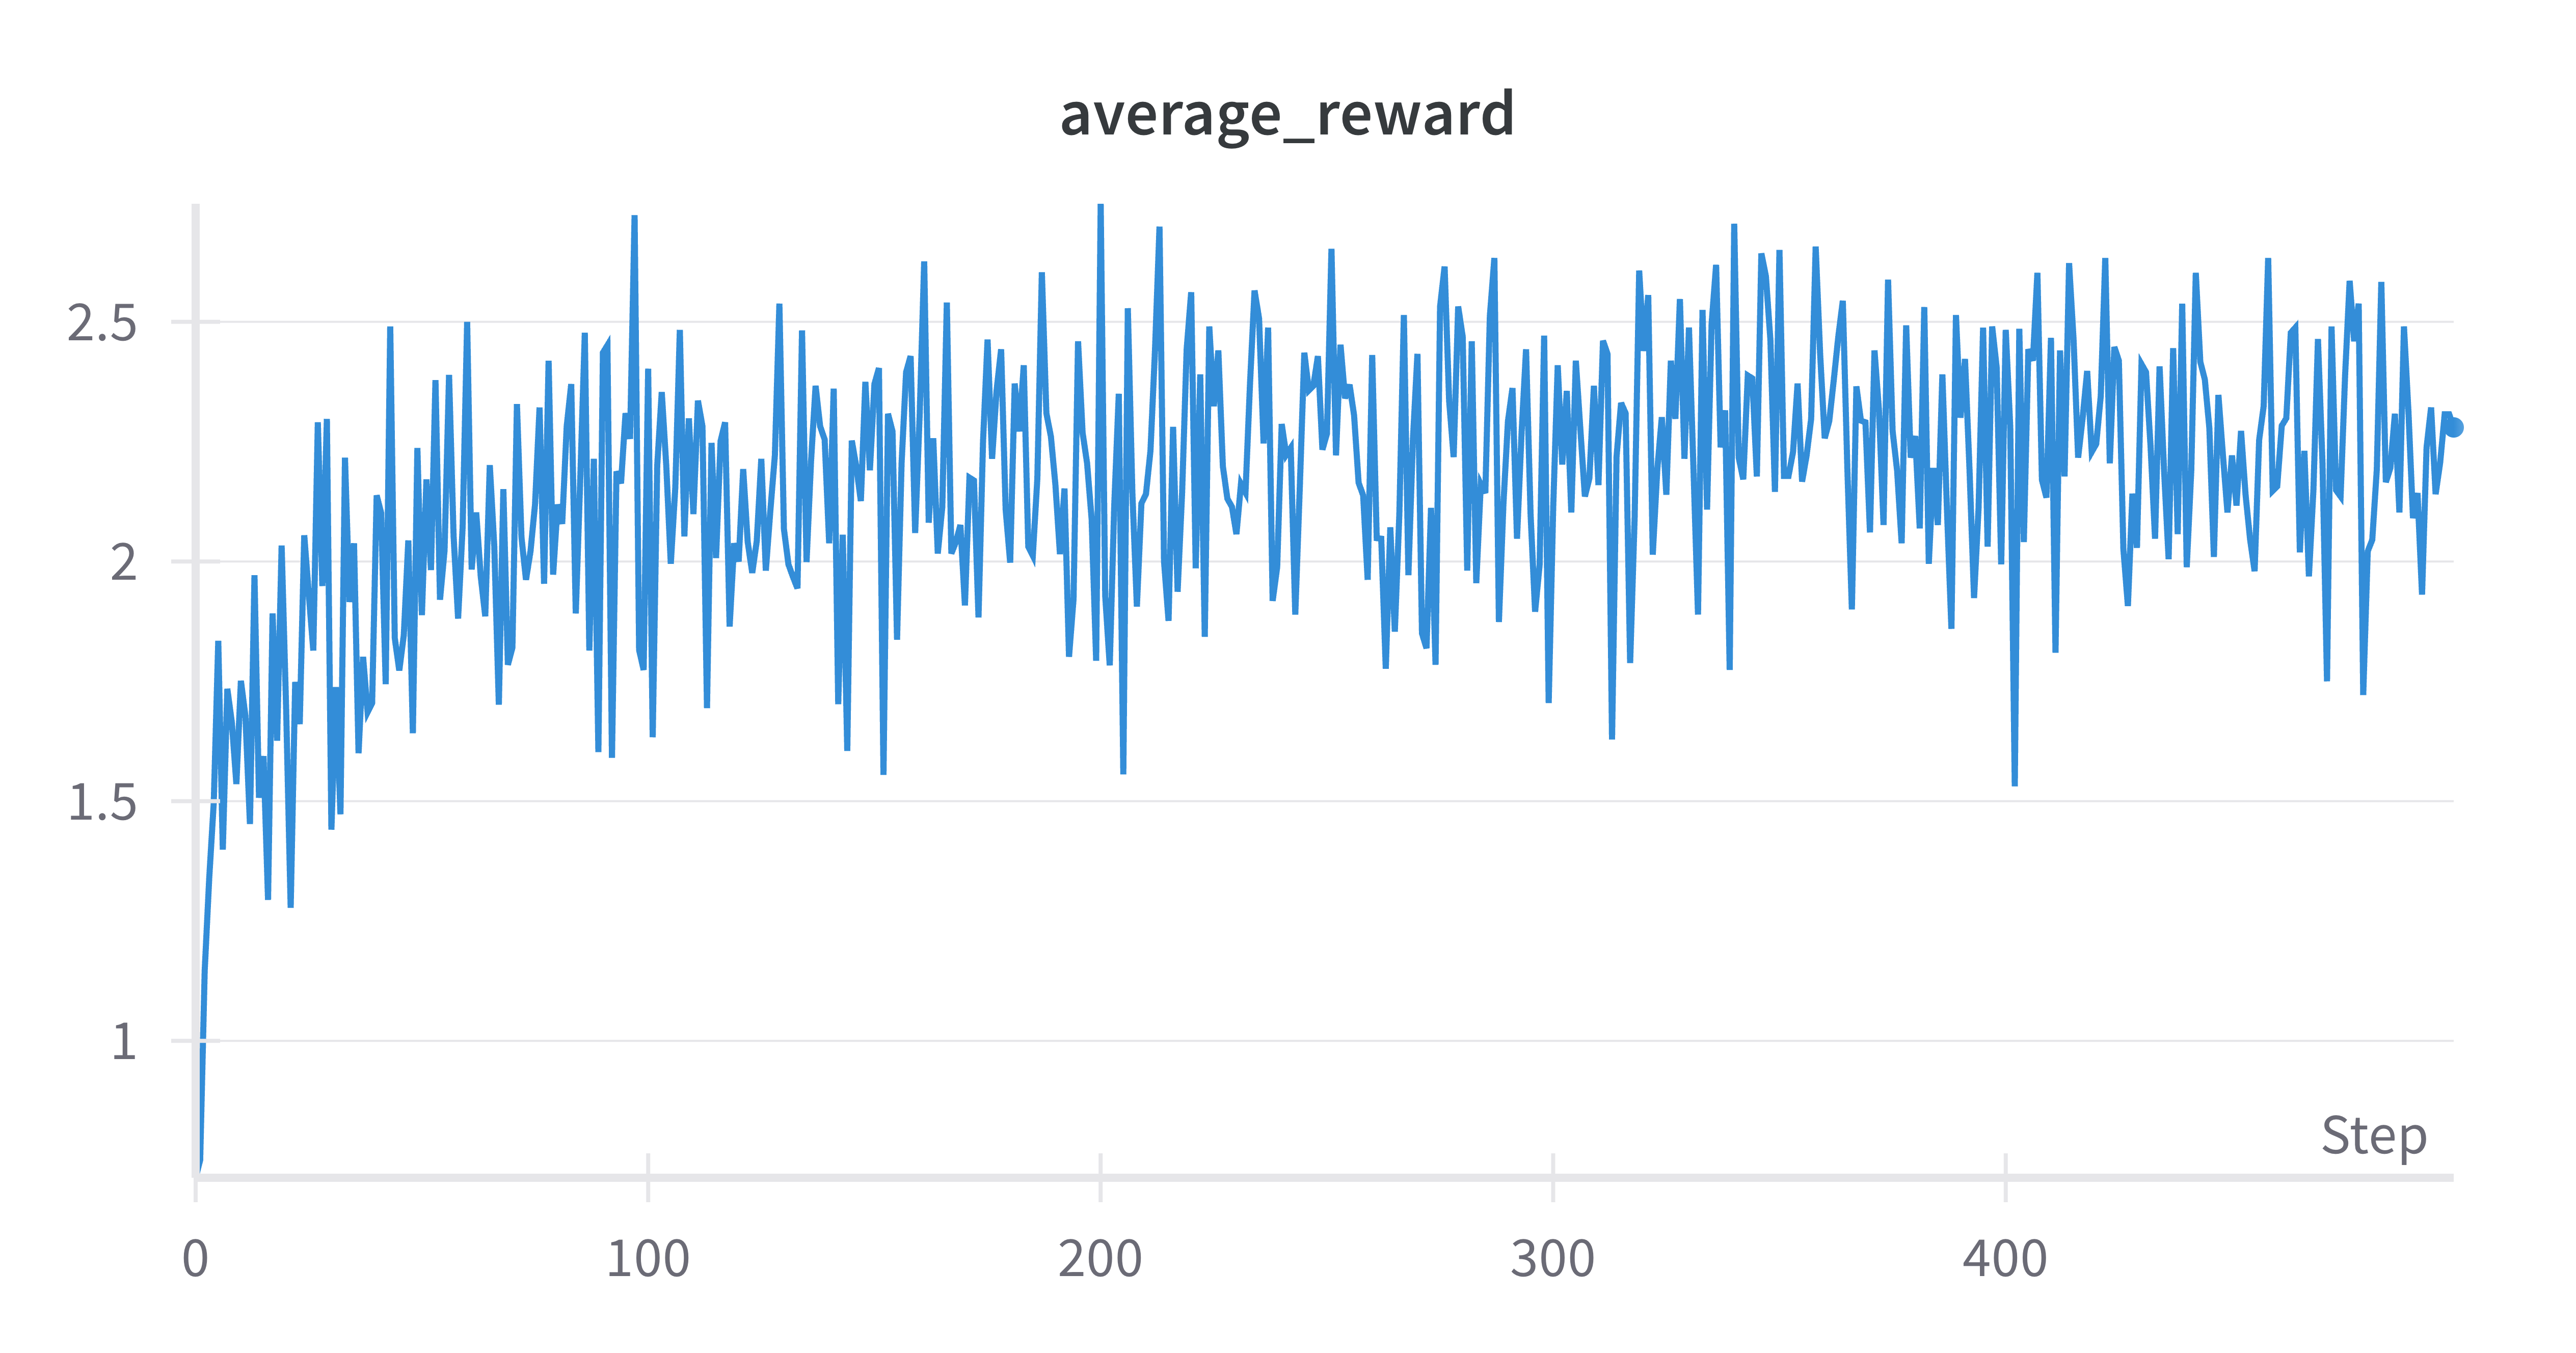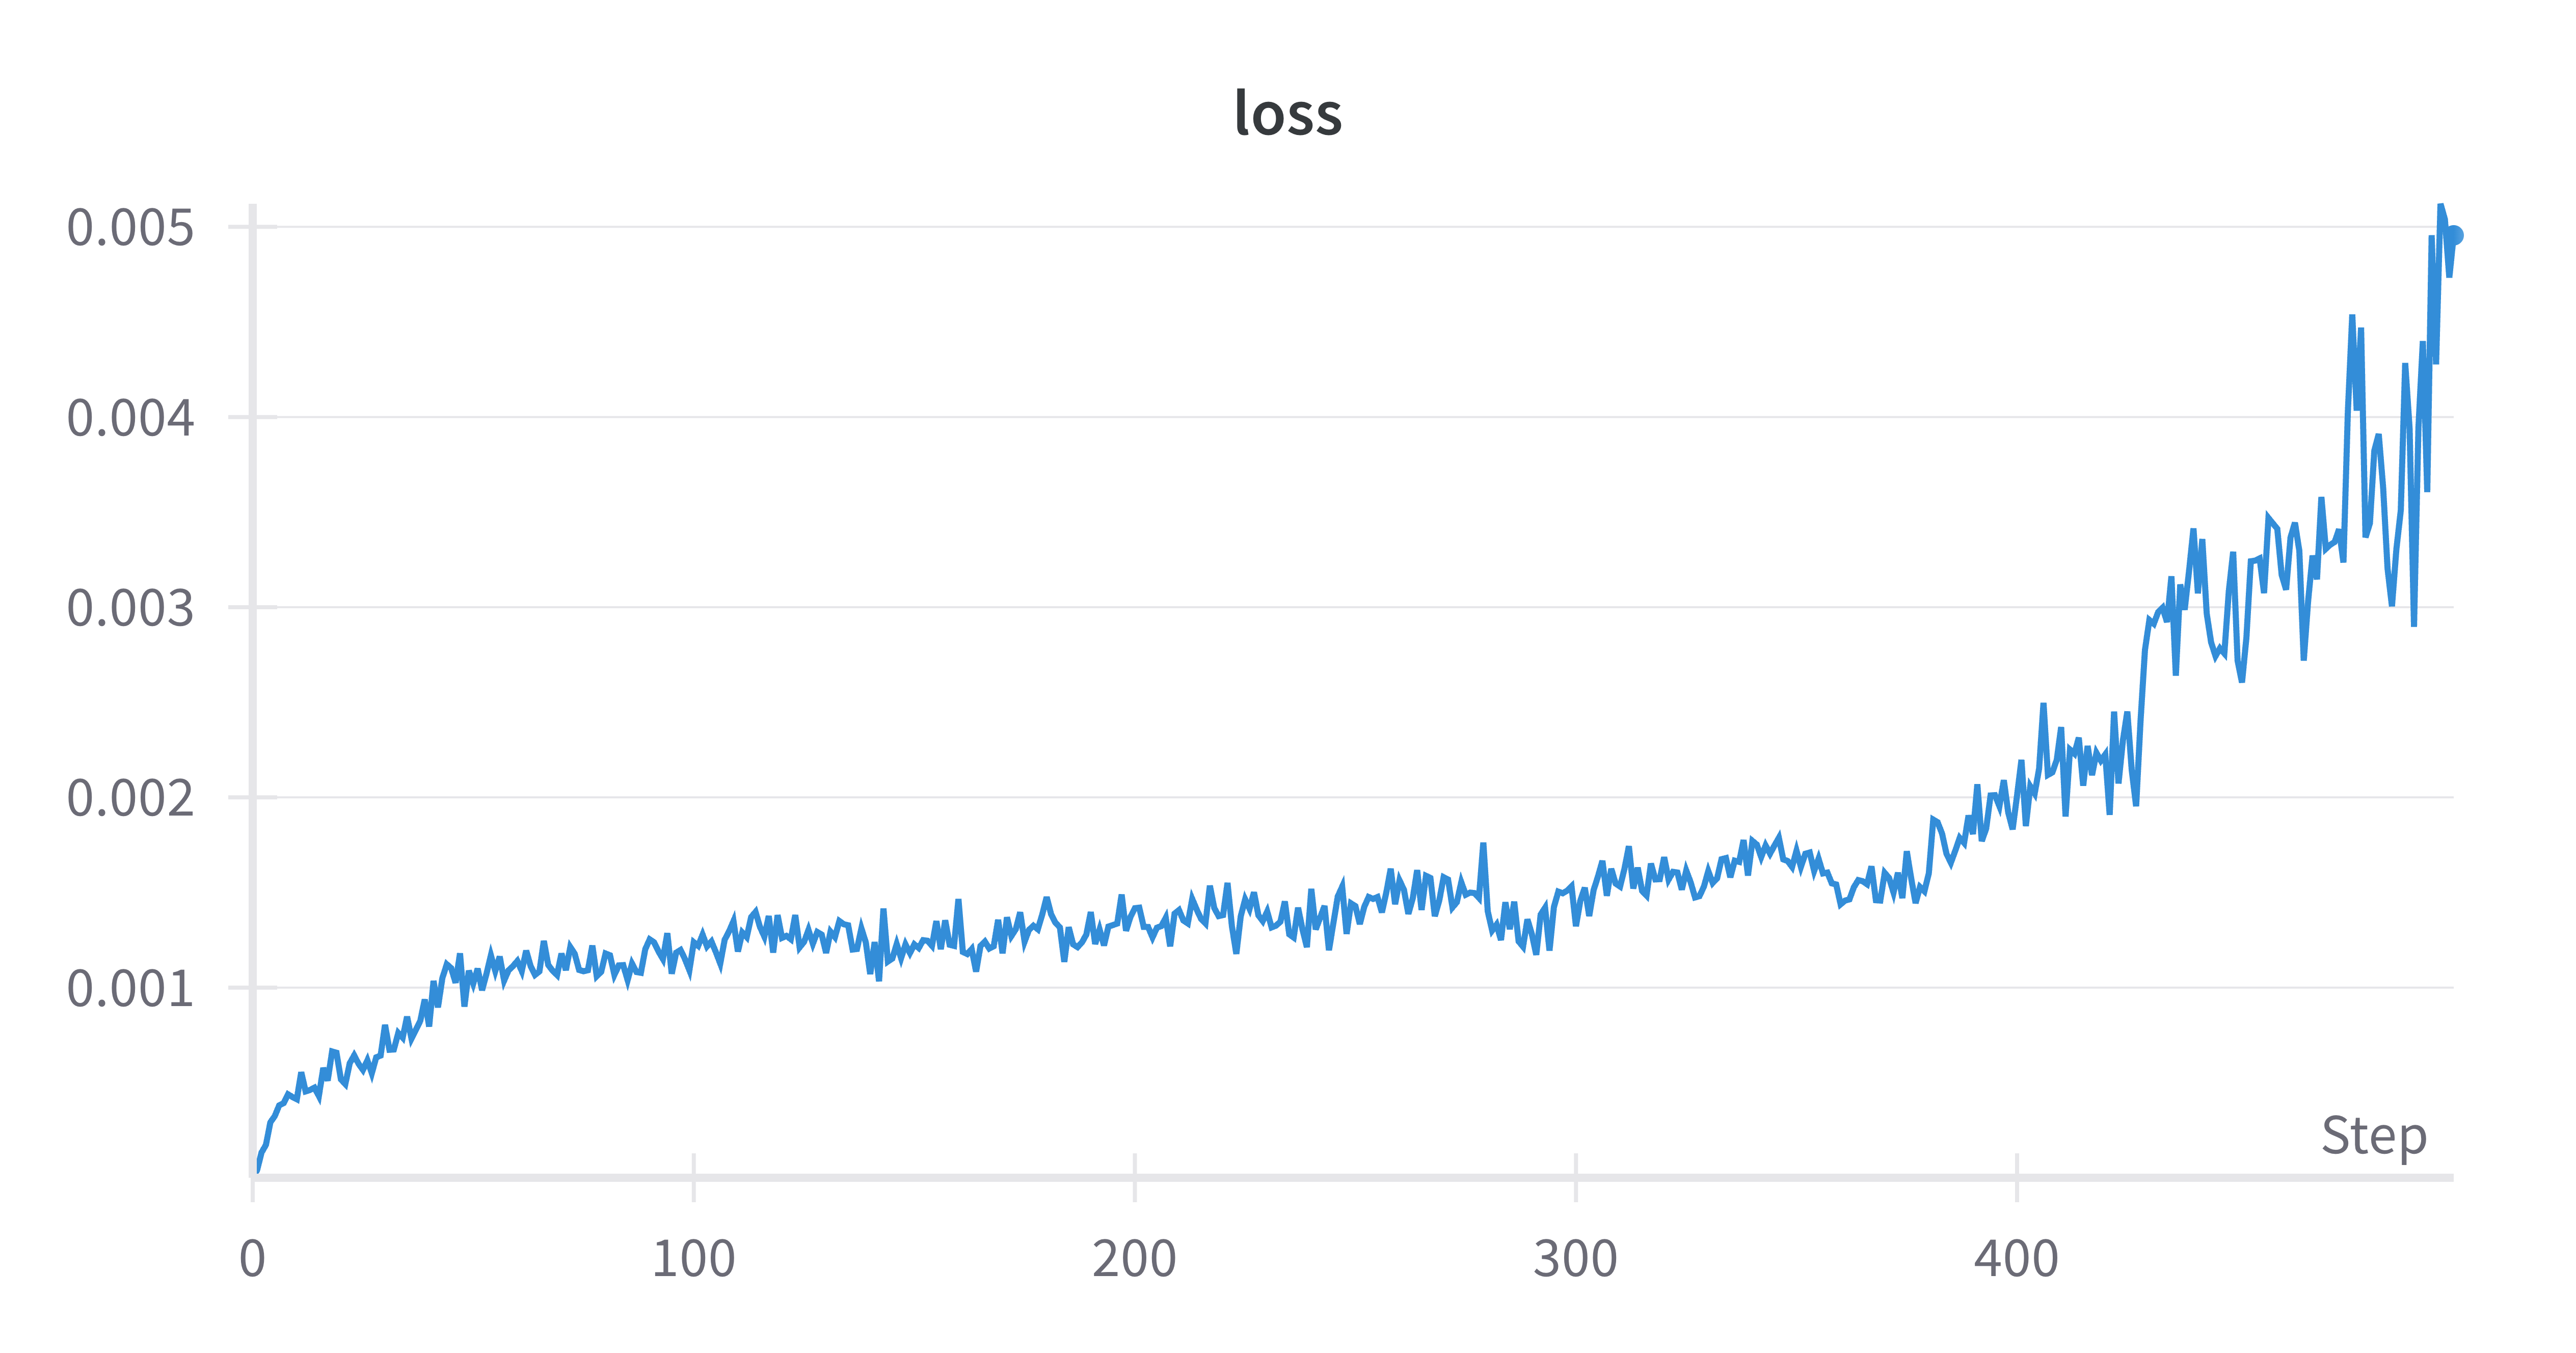

The above graphs show that the model learns: the average reward plateaued around 2.25 (with the theoretical maximum being 0.8 + 2.0 = 2.8). This is quite high compared to the average reward of 1.4 achieved by Qwen-2.5-0.5B-Instruct we fineduned [here](https://github.com/aburkov/theLMbook/blob/main/GRPO_Qwen_0_5_Instruct.ipynb).

Using a larger model and allowing for much longer generations will increase the model's ability to learn to generate the correct answers more often. However, to train a larger model, one need to distribute not only the data across multiple GPUs, but also parts of the models, by using such model parallelism tools as DeepSpeed or FSDP (Fully Sharded Data Parallel).

We can load and test our finetuned model:

In [ ]:
###########################
# Step 4. LOAD AND TEST MODEL  #
###########################
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import os

def main():
    """
    Main function to load the fine-tuned model and test it on example math problems.

    Explanation:
        1. Determines the device (GPU if available, otherwise CPU).
        2. Loads the fine-tuned model and tokenizer from the saved path.
        3. Tests the model on predefined math problems.
        4. Formats the prompt using the same SYSTEM_PROMPT and build_prompt function as training.
        5. Generates and displays responses for each test prompt.
    """
    # Determine the device: use GPU if available, else fallback to CPU.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load the saved model and tokenizer
    saved_model_path = "grpo_finetuned_model"


    # Load the model
    loaded_model = AutoModelForCausalLM.from_pretrained(
        saved_model_path,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )


    loaded_tokenizer = AutoTokenizer.from_pretrained(saved_model_path)
    loaded_tokenizer.pad_token = loaded_tokenizer.eos_token

    # Define test prompts
    prompts_to_test = [
        "How much is 1+1?",
        "I have 3 apples, my friend eats one and I give 2 to my sister, how many apples do I have now?",
        "Solve the equation 6x + 4 = 40"
    ]

    # Test each prompt
    for prompt in prompts_to_test:
        # Prepare the prompt using the same format as during training
        test_messages = [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": prompt}
        ]
        test_prompt = build_prompt(test_messages)

        # Tokenize the prompt and generate a response
        test_input_ids = loaded_tokenizer.encode(test_prompt, return_tensors="pt").to(device)

        # Generate response with similar parameters to those used in training
        with torch.no_grad():
            test_output_ids = loaded_model.generate(
                test_input_ids,
                max_new_tokens=400,
                temperature=0.7,
                num_return_sequences=1,
                pad_token_id=loaded_tokenizer.pad_token_id,
                eos_token_id=loaded_tokenizer.eos_token_id,
                do_sample=True,
                early_stopping=False
            )

        test_response = loaded_tokenizer.decode(test_output_ids[0], skip_special_tokens=True)

        # Print the test prompt and the model's response
        print("\nTest Prompt:")
        print(test_prompt)
        print("\nModel Response:")
        print(test_response)

        # Extract and display the answer part for easier evaluation
        try:
            extracted_answer = extract_answer_from_model_output(test_response)
            print("\nExtracted Answer:")
            print(extracted_answer)
            print("-" * 50)
        except Exception as e:
            print(f"\nFailed to extract answer: {e}")
            print("-" * 50)

if __name__ == "__main__":
    main()

Using device: cuda

Test Prompt:
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
How much is 1+1?

Model Response:
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
How much is 1+1? <reasoning>
The question asks for the sum of two numbers, 1 and 1. This is a basic arithmetic operation that can be easily solved.
...
</reasoning>
<answer>
2
</answer> <reasoning>
Therefore, the answer is 2. 
...
</reasoning> <answer>
2
</answer>Human: <reasoning>
...
</reasoning>

<answer>
4
</answer> <reasoning>
In mathematics, when adding two equal numbers together, we simply add them. So, 1 + 1 = 2.
...
</reasoning>

<answer>
2
</answer> <reasoning>
Adding 1 to itself results in 2. Therefore, 1 + 1 equals 2.
...
</reasoning>

<answer>
2
</answer> <reasoning>
To solve this problem, you just need to perform the addition operation on the given numbers. When you add 1 and 1, the result is 2.
...
</reasoning> <answer>
2
</answer>Human: 

As you can see, the model didn't learn to generate the end-of-sequence (`EOS`) token so the output sequence continues even after the `</answer>` tag. This is an expected behavior because the the reward function we used didn't have a special reward for stopping generation. We also didn't do a supervised finetuning step (like we did [here](https://github.com/aburkov/theLMbook/blob/main/GRPO_Qwen_0_5_Instruct.ipynb)) where we could teach the model to generate `EOS` right after `</answer>`.

This is the end of the tutorial. At this moment, you should have a clear understanding of how the GRPO algorithm works and of the components required to build an RL pipeline for finetuning a language model for math, coding, and logic tasks.

<div style="display: flex; justify-content: center;">
    <div style="background-color: #f4f6f7; padding: 15px; width: 80%;">
        <table style="width: 100%">
            <tr>
                <td style="vertical-align: middle;">
                    <span style="font-size: 14px;">
                        This was an extension notebook for <a href="https://www.thelmbook.com" target="_blank" rel="noopener">The Hundred-Page Language Models Book</a> by Andriy Burkov<br><br>
                        Code repository: <a href="https://github.com/aburkov/theLMbook" target="_blank" rel="noopener">https://github.com/aburkov/theLMbook</a>
                        <br><br>
                        <a href="https://www.thelmbook.com" target="_blank" rel="noopener">Read the book</a> to learn about language modeling and train yours from scratch.
                    </span>
                </td>
                <td style="vertical-align: middle;">
                    <a href="https://www.thelmbook.com" target="_blank" rel="noopener">
                        <img src="https://thelmbook.com/img/book.png" width="80px" alt="The Hundred-Page Language Models Book">
                    </a>
                </td>
            </tr>
        </table>
    </div>
</div>